In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # for extract lat, long
import matplotlib.path as mplPath
%matplotlib inline

In [394]:
# load in crime
c = pd.read_csv('bostonCrime.csv')

# change column names for easier use
c.columns = ['incident_id', 'offense_code', 'offense_group', 'offense_dis',
             'dist', 'report_area', 'shooting', 'date', 'hr', 'yr', 'mon',
             'day', 'ucr', 'street', 'lat', 'long', 'location']

# take a look
c.head()

,incident_id,offense_code,offense_group,offense_dis,dist,report_area,shooting,date,hr,yr,mon,day,ucr,street,lat,long,location
0,I162004042,3115,Investigate Person,INVESTIGATE PERSON,D4,128.0,NaN,01/15/2016 12:30:00 PM,12,2016,1,Friday,Part Three,STANHOPE ST,42.348689,-71.072580,"(42.34868917, -71.07257992)"
1,I162008304,3502,Missing Person Located,MISSING PERSON - LOCATED,B3,458.0,NaN,01/31/2016 12:36:00 PM,12,2016,1,Sunday,Part Three,ELLINGTON ST,42.301974,-71.083834,"(42.3019742, -71.08383388)"
2,I162073291,3201,Property Lost,PROPERTY - LOST,D4,597.0,NaN,09/08/2016 07:16:00 PM,19,2016,9,Thursday,Part Three,COLUMBUS AVE,42.340125,-71.082233,"(42.34012548, -71.0822333)"
3,I162013074,2900,Other,VAL - VIOLATION OF AUTO LAW - OTHER,D14,806.0,NaN,02/18/2016 06:00:00 PM,18,2016,2,Thursday,Part Two,TELFORD ST,42.362903,-71.137378,"(42.36290257, -71.13737847)"
4,I152066279,301,Robbery,ROBBERY - STREET,C6,214.0,NaN,08/10/2015 11:47:00 PM,23,2015,8,Monday,Part One,NaN,NaN,NaN,"(0E-8, 0E-8)"


In [395]:
# filter out miss values which are strange long, lat values
c = c[np.isfinite(c.lat)]



(array([ 6867.,  4276.,  3574.,  2131.,  1551.,  1517.,  2249.,  4070.,
         6021.,  6915.,  7508.,  7542.,  8722.,  7735.,  7969.,  7518.,
         9098.,  9594.,  9419.,  8136.,  7398.,  6392.,  6059.,  4944.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

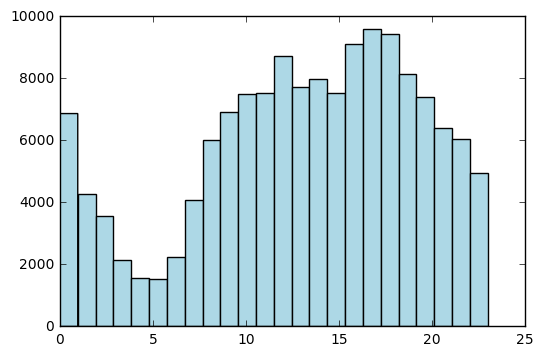

In [396]:
# take a look crime time distribution
plt.hist(c.hr,24,  facecolor='lightblue')


In [397]:
# can take a look of the time distribution by different crimes

In [398]:
# take a look of shooting percentage
c.shooting.value_counts() / len(c) * 100

Y    0.309772
Name: shooting, dtype: float64

In [399]:
# create a zipcode tag to summarize crime data
z = pd.read_csv('isd_neighborhood_districts.csv')
z.columns

Index([u'the_geom', u'Name', u'Shape_area', u'Shape_len'], dtype='object')

In [400]:
# create boston boundary dictionary
bostonBoundary = {}
for i in xrange(len(z)):
    name = z.Name[i]
    county = re.findall(r'\((.*?)\)', z.the_geom[i]) # get towns' polygon
    j = 0
    for town in county:
        res = re.findall(r'(-\d{2}\.\d+)\s(\d{2}\.\d+)', town) # get polygon's lat and long
        res = [(float(lon), float(lat)) for lon, lat in res]
        bostonBoundary[name + ' ' + str(j)] = res
        j += 1


In [401]:
# to see each crime belongs to which boston area
lat_long = zip(c.long, c.lat)
c2 = pd.DataFrame()
c['region'] = 'NA'
for i in bostonBoundary.keys():
    check = mplPath.Path(np.array(bostonBoundary[i]))
    res = check.contains_points(lat_long)
    tmp = c[res]
    tmp.region = i[:-2]
    c2 = c2.append(tmp, ignore_index=True)

In [402]:
# switch 
c, c2 = c2, c

In [403]:
c.detail = c.groupby(['region', 'offense_group']).size()
c.detail = c.detail.unstack().fillna(0)
c.detail['total'] = c.detail.sum(axis=1)
c.detail['percentage'] = c.detail.total / c.detail.total.sum() * 100


In [404]:
# export as csv
c.detail.to_csv('crimeByRegion.csv')

In [412]:
# import csv
# with open('bostonBoundary-2.csv', 'wb') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(['Region','long','lat'])
#     for i in xrange(len(z)):
#         name = z.Name[i]
#         res = re.findall(r'(-\d{2}\.\d+)\s(\d{2}\.\d+)', z.the_geom[i]) # get towns' polygon
#         for lon, lat in res:
#             writer.writerow([name, lon, lat])




In [415]:
# to export boston boundary
import csv
with open('bostonBoundary.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Region', 'path_id','long','lat'])
    for key, value in bostonBoundary.items():
        path = 0
        for i in value:
            writer.writerow([key[:-2], path, i[0], i[1]])
            path += 1

In [ ]:
# http://gis.stackexchange.com/questions/36877/how-do-i-change-the-polygon-fill-color-and-border-color-for-spatialpolygons-obje
# use R to plot polygon


[]

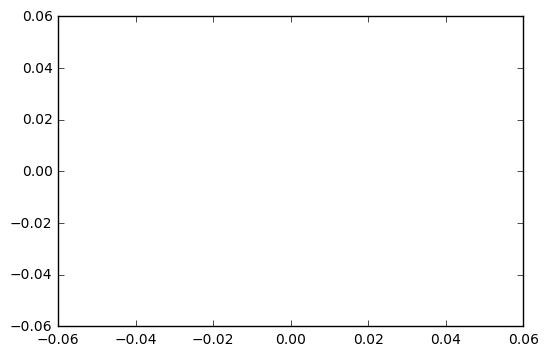

In [436]:

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# fig, ax = plt.subplots()
patches = []

for i in bostonBoundary:
    polygon = Polygon(np.array(bostonBoundary[i]), True)
    patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

colors = 100*np.random.rand(len(patches))
p.set_array(np.array(colors))

# ax.add_collection(p)
plt.plot()


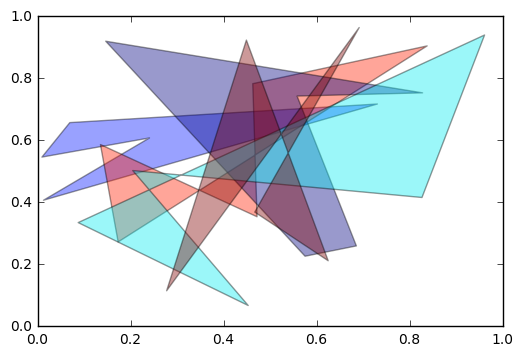

In [422]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
patches = []
N = 5

for i in range(N):
    polygon = Polygon(np.random.rand(N,2), True)
    patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

colors = 100*np.random.rand(len(patches))
p.set_array(np.array(colors))

ax.add_collection(p)

plt.show()

In [442]:
# http://stackoverflow.com/questions/26935701/ploting-filled-polygons-in-python